In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Convoluções como detectores de características

Um dos usos mais populares de convoluções é o de detector de catacterísticas de imagem. Considere a imagem abaixo:

In [2]:
def plot_image(img, figsize=(12,12), axis='off'):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis(axis)
    plt.show()

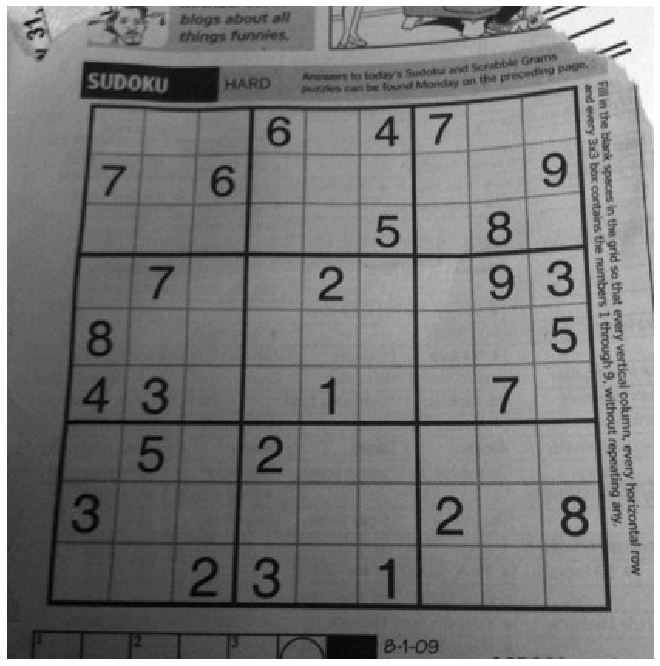

In [3]:
img_original = cv2.cvtColor(cv2.imread('sudoku-original.jpg'), cv2.COLOR_BGR2GRAY)
plot_image(img_original)

Vamos aplicar o CLAHE para melhorar o contraste da imagem:

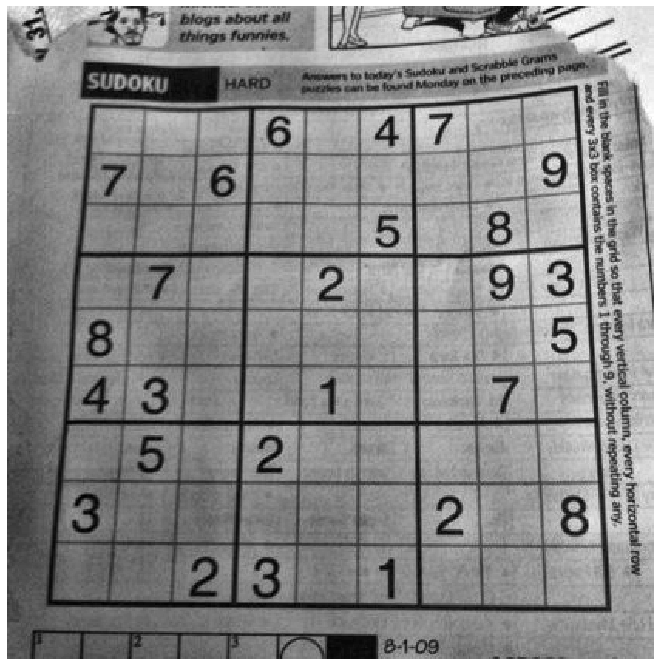

In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15, 15))
img = clahe.apply(img_original)

img = img / 255.0

plot_image(img)

Suponha que queremos localizar as ocorrências do dígito 5 na imagem. Vamos buscar as localizações candidatas por similaridade a um padrão de referência, obtido a partir da própria imagem. Essa técnica é conhecida como *template matching*.

Vamos recortar um dos padrões de digito 5. Vamos também remover a média e normalizar para que a soma dos quadrados dos valores seja unitária. Isso impede que o resultado da convolução saia muito da escala de valores original da imagem.

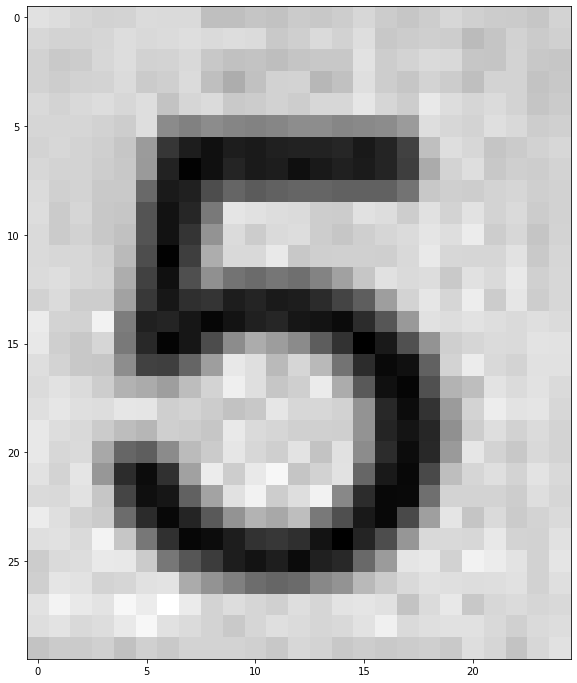

In [5]:
kernel_five = img[130:160, 235:260]
kernel_five = kernel_five - np.mean(kernel_five)
kernel_five = kernel_five / np.sum(kernel_five ** 2)
plot_image(kernel_five, axis='on')

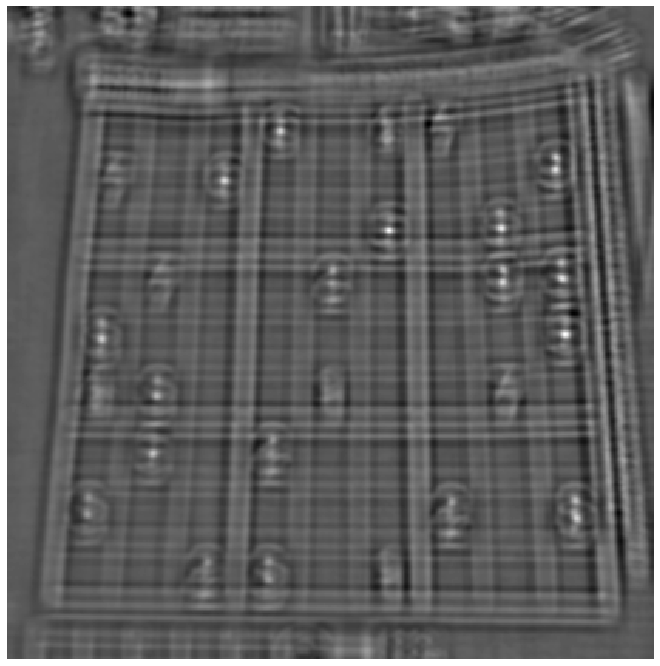

In [6]:
img_five = cv2.filter2D(img, -1, kernel_five)  # IMPORTANTE: filter2D NÃO FLIPA-FLIPA! Calcula correlação ao invés de convolução.
plot_image(img_five)

In [7]:
from skimage.morphology import h_maxima, local_maxima

peaks = local_maxima(h_maxima(img_five, 0.5), indices=True)
print(len(peaks[0]))

13


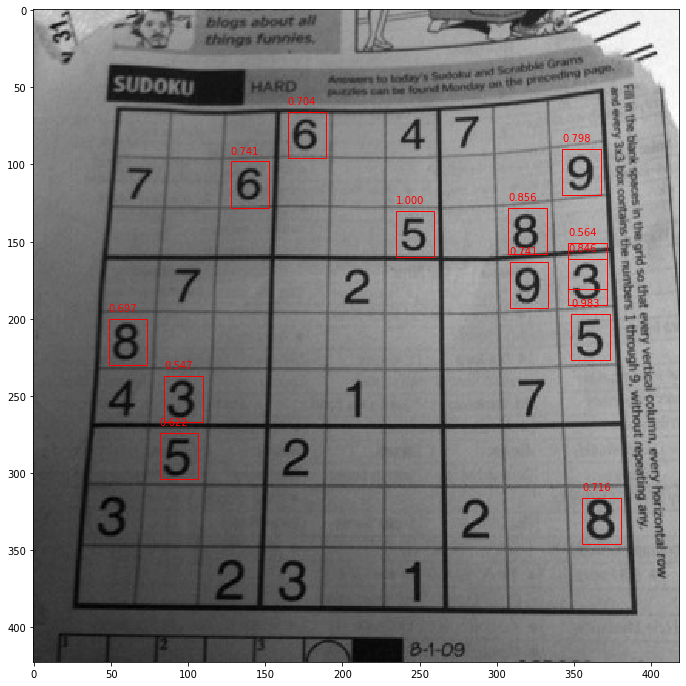

In [8]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 12))
plt.imshow(img_original, cmap='gray')
width, height = kernel_five.shape
for x, y in zip(peaks[0], peaks[1]):
    plt.gca().add_patch(Rectangle((y - height/2, x - width/2), height, width, linewidth=1, edgecolor='r',facecolor='none'))
    plt.text(y - height/2, x - width/2 - 5, f'{str(img_five[x,y]):.5}', color='red')


**Atividade:** 

- Explique os falsos positivos!

- Fizemos algo util aqui? Sim, nao, talvez, depende? Explique.

**R:**

## Convolução como operador matemático

Podemos usar a convolução como uma aproximação de operadores matemáticos. Por exemplo, considere a definição de derivada parcial de um sinal:

$$
\frac{\partial}{\partial x} f(x, y) = \lim_{h \rightarrow 0} \frac{f(x + h) - f(x)}{h}
$$

No caso discreto, podemos aproximar a derivada como uma operação de diferença entre posições consecutivas (implicitamente adotando $h = 1$, fica ao gosto do freguês):

$$
f_{x}[i, j] = f[i, j + 1] - f[i, j]
$$

Esta operação é uma transformação de uma imagem $f[i,j]$ em uma imagem $f_{x}[i,j]$. Esta transformação é linear? Esta transformação é invariante ao deslocamento? (Dica: sim, e sim. Prove)

**R:**

Esta transformação é um filtro linear e invariante ao deslocamento. Significa que pode ser representada por uma convolução. Eis o *kernel* correspondente:

$$
h_{x}[i,j] = \left[
\begin{matrix}
(1) & -1
\end{matrix}
\right]
$$

Os parênteses, como de costume, indicam a origem espacial do kernel (nosso querido "meinho").

Eis a implementação desta derivada parcial em Python:

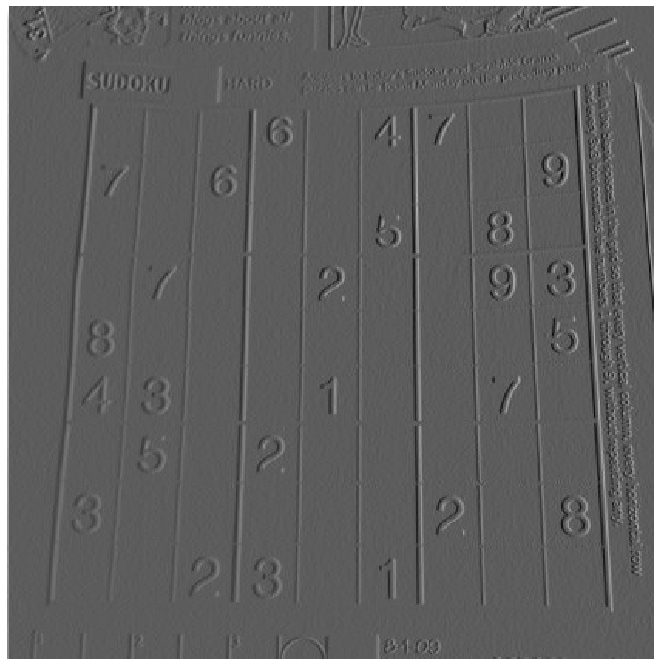

In [23]:
img = img_original / 255.0  # Firula, não é necessário.

# Eis o kernel! Note que estamos construindo uma *matriz*, não um vetor simples.
kernel_x = np.array([
    [1, -1]
])

# Vou usar a convolução do numpy, só para ser diferente. 
# Se fosse usar a do OpenCV tinha que prestar atenção no FLIPA-FLIPA, ok?
from scipy.signal import convolve2d

img_dx = convolve2d(img, kernel_x, 'same')

plot_image(img_dx)

**Atividade:** Como seria a aproximação de $\frac{\partial}{\partial y}$?

**R:**

**Atividade:** Qual o *kernel* correspondente neste caso?

**R:**

**Atividade:** Calcule a derivada em $y$ da imagem de teste

A segunda derivada é a aplicação da derivada duas vezes:

$$
\frac{\partial^2}{\partial x^2} f(x,y) = \frac{\partial}{\partial x} \left(\frac{\partial}{\partial x} f(x,y)\right) 
$$

Na nossa aproximação numérica, temos:

$$
f_{xx} = h_{x} * (h_{x} * f) = (h_x * h_x) * f = h_{xx} * f
$$

onde

$$
h_{xx} = h_{x} * h_{x} = 
\left[ 
\begin{matrix}
(1) & -1
\end{matrix}
\right] * \left[ 
\begin{matrix}
(1) & -1
\end{matrix}
\right] = 
\left[ 
\begin{matrix}
(1) & -2 & 1
\end{matrix}
\right]
$$

Por conveniência, vamos mudar o "meinho" para o meio do *kernel*, assim a aplicação do *kernel* não implicará em um deslocamento implícito da imagem. Ficamos então com:

$$
h_{xx} = \left[ 
\begin{matrix}
1 & (-2) & 1
\end{matrix}
\right]
$$

Eis a aplicação deste kernel para nossa imagem de teste:

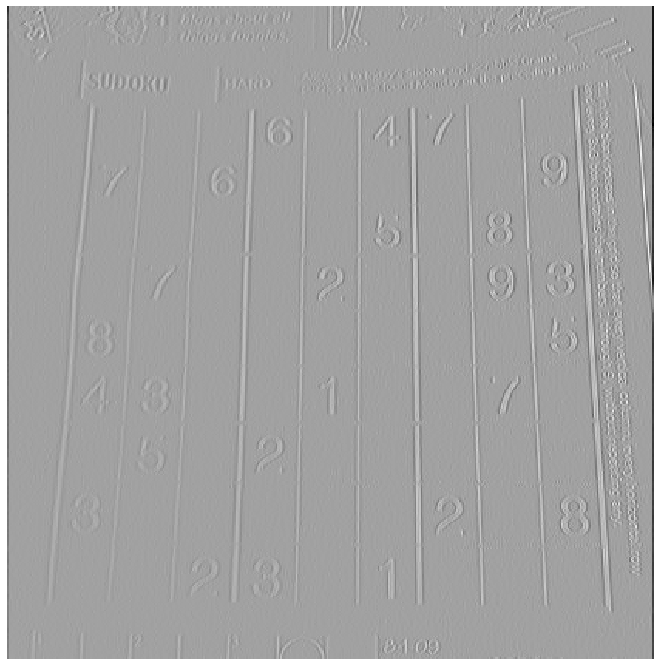

In [11]:
kernel_xx = np.array([
    [1, -2, 1]
])

img_dxx = convolve2d(img, kernel_xx, 'same')

plot_image(img_dxx)

**Atividade:** 

- Porque as linhas horizontais sumiram?

- Porque as linhas verticais ficaram claras em relação ao fundo?

**R:**

**Atividade:** Implemente as demais segundas derivadas e calcule `img_dyy` e `img_dxy`.

**Atividade:** É necessário calcular `img_dyx`? Prove.

Nas aulas seguintes vamos usar essas segundas derivadas para construir um detector de pontos de interesse que será a base do projeto de estabilização de câmera!

O operador laplaciano é definido como:

$$
\nabla^2 f(x,y) = \frac{\partial^2}{\partial x^2} f(x,y) + \frac{\partial^2}{\partial y^2} f(x,y)
$$

Na nossa aproximação numérica, temos:

$$
\nabla^2 f = h_{xx} * f + h_{yy} * f = (h_{xx} + h_{yy}) * f
$$

Cuidado ao somar $h_{xx}$ e $h_{yy}$: as matrizes não tem o mesmo tamanho nem o mesmo "meinho". Para fazer isso funcionar, usamos o *zero-padding*:

$$
h_{xx} = \left[
\begin{matrix}
0 & 0 & 0 \\
1 & (-2) & 1 \\
0 & 0 & 0
\end{matrix}
\right]
$$

e

$$
h_{yy} = \left[
\begin{matrix}
0 & 1 & 0 \\
0 & (-2) & 0 \\
0 & 1 & 0
\end{matrix}
\right]
$$

Agora podemos somar os *kernels*, resultando em:

$$
h_{laplacian} = \left[
\begin{matrix}
0 & 1 & 0 \\
1 & (-4) & 1 \\
0 & 1 & 0
\end{matrix}
\right]
$$


Vamos calcular o laplaciano para a imagem de teste:

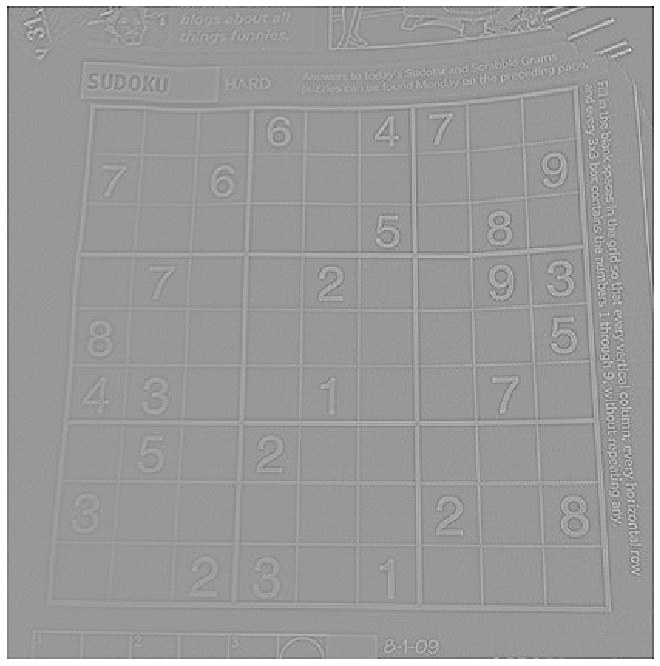

In [12]:
kernel_lapla = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

img_lapla = convolve2d(img, kernel_lapla, 'same')
plot_image(img_lapla)

Agora vamos aplicar esse Laplaciano para alguma coisa. O que acontece se tomarmos a imagem de teste e subtrairmos uma fração (digamos, $\alpha$) do Laplaciano?

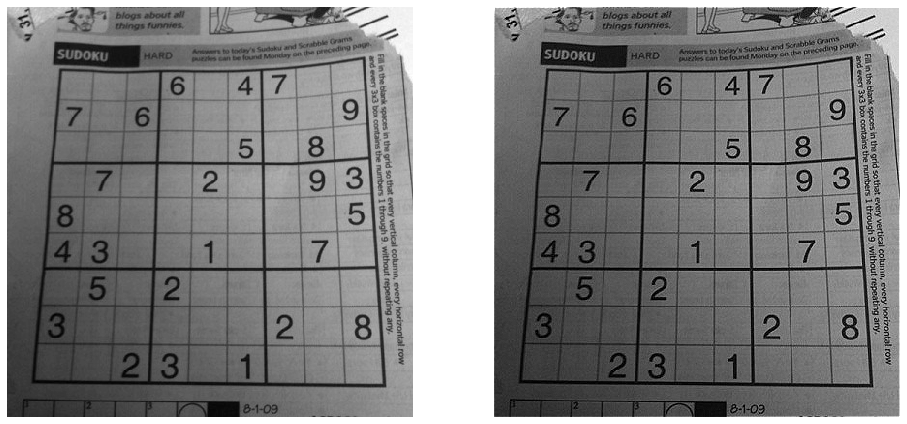

In [13]:
alpha = 0.5
img_enhance = img - alpha*img_lapla
img_enhance = np.clip(img_enhance, 0, 1)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
        
plt.subplot(1, 2, 2)
plt.imshow(img_enhance, cmap='gray')
plt.axis('off')

plt.show()

Note que o resultado obtido foi um realce das bordas da imagem!

**Atividade:** Construa um *kernel* que executa a operação de realce em uma só convolução.

**R:**

## Transformações geométricas

### Escala

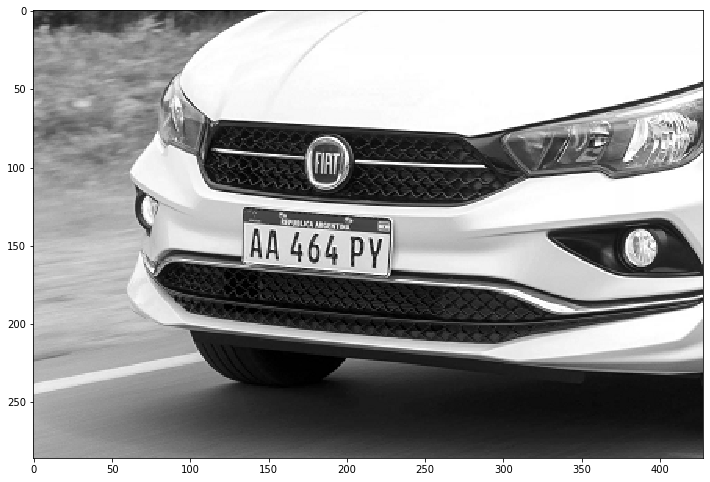

In [14]:
img = cv2.cvtColor(cv2.imread('carro.png'), cv2.COLOR_BGR2GRAY) / 255.0

plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray');

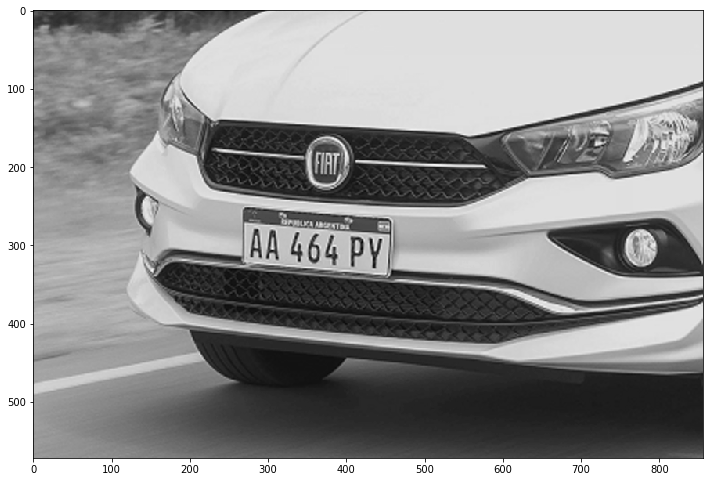

In [15]:
img_zoom = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(12,12))
plt.imshow(img_zoom, cmap='gray');  # Observe os labels dos eixos.

### Translação

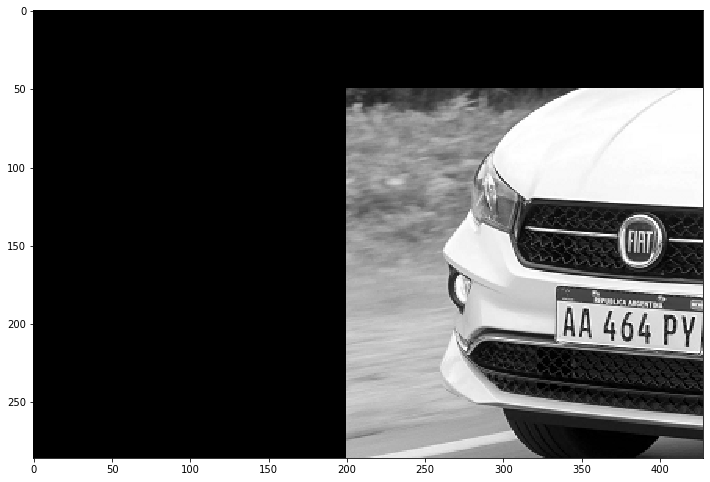

In [16]:
rows, cols = img.shape

M = np.array([[1, 0, 200], [0, 1, 50]], dtype=np.float32)
img_shifted = cv2.warpAffine(img, M, (cols,rows))  # Terceiro argumento é o tamanho da imagem resultante.
plt.figure(figsize=(12,12))
plt.imshow(img_shifted, cmap='gray');

### Rotação

In [17]:
# Primeiro, definir o ponto de rotação.
rows, cols = img.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2), 30, 1)  # O terceiro argumento é escala.
print(M)

[[  0.8660254    0.5        -42.82943641]
 [ -0.5          0.8660254  126.15836726]]


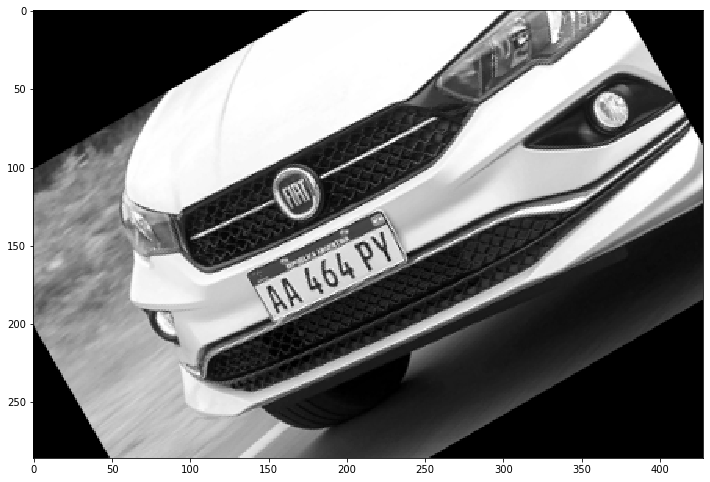

In [18]:
# Agora aplicar a rotação.
img_rot = cv2.warpAffine(img, M, (cols,rows))
plt.figure(figsize=(12,12))
plt.imshow(img_rot, cmap='gray');

Veja em https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#getrotationmatrix2d a matemática da matriz afim de rotação

### Perspectiva

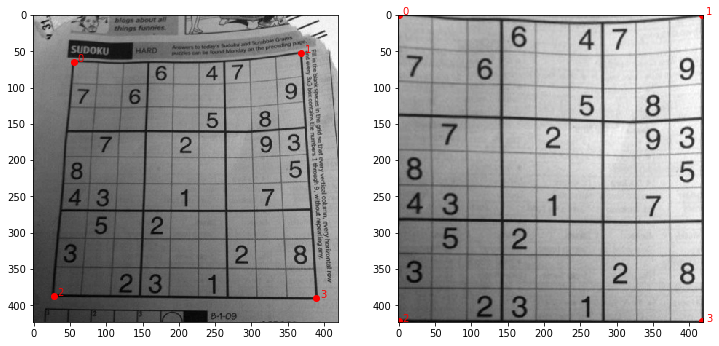

In [8]:
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
img = cv2.cvtColor(cv2.imread('sudoku-original.jpg'), cv2.COLOR_BGR2GRAY) / 255.0
rows, cols = img.shape

pts_original = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts_corrigida = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [ cols - 1, rows - 1]])

M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

img_corrigida = cv2.warpPerspective(img, M, (cols, rows))

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img, cmap='gray')
for k, p in enumerate(pts_original):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')

plt.subplot(122)
plt.imshow(img_corrigida, cmap='gray')
for k, p in enumerate(pts_corrigida):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')
plt.show()

**Atividade:** Gere uma imagem da placa do carro, com a perspectiva corrigida.